In [1]:
from util import *

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']
Add path ../../..
Connected DB


In [2]:
import os
import numpy as np

In [3]:
import matplotlib.image as mpimg

In [4]:
from IPython.display import HTML

# NAMESPACE

In [5]:
class NAMESPACE:
    # Base values
    TABLE_NAME = 'DW_COLLATERAL_FCT'
    SEL_SAMPLE = 'SAMPLE1_SUB1'
    
    # Important to look
    QUERY = f"""SELECT X.* FROM DW_ANALYTICS.{TABLE_NAME} X JOIN CINS_TMP_ALY_CUST_{SEL_SAMPLE} SAM ON X.CUSTOMER_CDE = SAM.CUSTOMER_CDE"""
    
    # Derived values
    data_fp = f'./data/{TABLE_NAME}'
    data_sample_nm = os.path.join(data_fp, SEL_SAMPLE)
    IMG_FP = f'./img/{TABLE_NAME}'
    img = f'./img/{TABLE_NAME}/{SEL_SAMPLE}'
    
    def show():
        atts = dir(NAMESPACE)
        for a in atts:
            if not a.startswith('__'):
                print(a)
    
    @classmethod
    def init(cls):
        if not os.path.exists(NAMESPACE.data_fp):
            os.makedirs(NAMESPACE.data_fp)
        if not os.path.exists(NAMESPACE.img):
            os.makedirs(NAMESPACE.img)

In [6]:
NAMESPACE.QUERY

'SELECT X.* FROM DW_ANALYTICS.DW_COLLATERAL_FCT X JOIN CINS_TMP_ALY_CUST_SAMPLE1_SUB1 SAM ON X.CUSTOMER_CDE = SAM.CUSTOMER_CDE'

In [7]:
NAMESPACE.init()

In [8]:
NAMESPACE.show()

IMG_FP
QUERY
SEL_SAMPLE
TABLE_NAME
data_fp
data_sample_nm
img
init
show


In [9]:
stat_opt = [
            'count',
            'mean',
            'median',
            'min',
            'max',
            'std',
]
ordered_stat_opt = [[i, i + '_pct_chg'] for i in stat_opt]
ordered_stat_opt = [j for i in ordered_stat_opt for j in i]

# Functions

In [10]:
def aly_datetime(df, date_col, cde_col, resample='1Y', outlier_date='1930-01-01', timedelta='365 days',lvl=3):
    display(HTML(f'<h{lvl}>{date_col}</h{lvl}>'))
    if cde_col is None:
        tmp_df = df[date_col].copy()
        tmp_df[date_col] = pd.to_datetime(tmp_df[date_col], errors='coerce')
        tmp_df[date_col] = df[date_col].astype('datetime64[D]')
        tmp = tmp_df[tmp_df[date_col] > outlier_date]
        plot_df = tmp.set_index(date_col).resample(resample).nunique()
    else:
        tmp_df = df[[date_col, cde_col]].copy()
        tmp_df[date_col] = pd.to_datetime(tmp_df[date_col], errors='coerce')
        tmp_df[date_col] = df[date_col].astype('datetime64[D]')
        tmp = tmp_df[tmp_df[date_col] > outlier_date]
        plot_df = tmp.set_index(date_col)[cde_col].resample(resample).nunique()
    
    fig, axs = plt.subplots(1,2, figsize=(15, 5))
    plot_df.plot(kind='bar', rot=70, ax=axs[0])
    up2now = ((datetime(2023,11,1) - tmp[date_col]) / pd.Timedelta(timedelta)).apply(float)
    sns.histplot(up2now, kde=True, ax=axs[1])
    plt.show()

In [11]:
def default_func(x):
    return x

In [12]:
def remove_mode_value(x):
    return x[~x.isin(x.mode().values)]

In [13]:
def logx(x):
    return np.log(x)

In [14]:
def plot_multi_hist_aly(df,cols=[],funcs=[default_func, remove_mode_value, logx], lvl=3):
    def df_stat_after_transformed(df_trans):
        def pct_change(series):
            first_e = series.iloc[0]
            pct_chg = (series - first_e) / first_e * 100
            pct_chg.iloc[0] = 100.
            return pct_chg
        stat_infos = []
        for data_trans_series in df_trans:
            # Get stats info
            stat_info = []
            for s in stat_opt:
                if s == 'count':
                    stat_info.append(data_trans_series.count())
                elif s == 'mean':
                    stat_info.append(data_trans_series.mean())
                elif s == 'median':
                    stat_info.append(data_trans_series.median())
                elif s == 'min':
                    stat_info.append(data_trans_series.min())
                elif s == 'max':
                    stat_info.append(data_trans_series.max())
                elif s == 'std':
                    stat_info.append(data_trans_series.std())
            stat_infos.append(stat_info)
        col_stat = stat_opt
        index_stat = [f.__name__ for f in funcs]
        stat_df = pd.DataFrame(data=stat_infos, columns=col_stat, index=index_stat)
        for c in stat_df.columns:
            stat_df[f'{c}_pct_chg'] = pct_change(stat_df[c])
        stat_df = stat_df[ordered_stat_opt]
        result_df = stat_df.T
        return result_df
    
    nrows, ncols = len(cols), len(funcs)
    for i, c in enumerate(cols):
        display(HTML(f'<h{lvl}>{c}</h{lvl}>'))
        if c in df.columns:
            data_trans = []
            for f in funcs:
                pre_data_tran = data_trans[-1] if len(data_trans) > 0 else df[c]
                trans_data = f(pre_data_tran)
                data_trans.append(trans_data)
            # plot section 
            fig, axs = plt.subplots(1,ncols, figsize=(4* ncols, 4 ))
            for j, d in enumerate(data_trans):
                sel_ax = axs[j]
                sel_ax.set_title(f'{cols[i]}\n{funcs[j].__name__}')
                d.replace([np.inf, -np.inf], np.nan).plot(kind='hist',bins=100,ax=sel_ax)
            pd.options.display.float_format = '{:.3f}'.format
            display(df_stat_after_transformed(data_trans))
            plt.tight_layout()
            plt.savefig(os.path.join(NAMESPACE.img, f'{c}.jpg'), dpi=500)
            plt.show()
            print('\n\n\n')

In [15]:
def aly_cat_col(df,cat_cols,k=10, lvl=3):
    for cat_col in cat_cols: 
        display(HTML(f'<h{lvl}>{cat_col}</h{lvl}>'))
        fig,axs=plt.subplots(1,2,figsize=(10,5))
        display(df[cat_col].value_counts())
        df[cat_col].value_counts()[:k].plot(kind='bar', rot=80,ax=axs[0])
        df[cat_col].value_counts()[:k].plot(kind='pie', autopct='%.2f%%',ax=axs[1])
        plt.savefig(os.path.join(NAMESPACE.img, f'{cat_col}.jpg'), dpi=500)
        plt.show()

In [16]:
def download_or_reload(saved_file):
    if not os.path.exists(saved_file):
        query = NAMESPACE.QUERY
        cur.execute(query)
        result = cur.fetchall()
        column_names = [c[0] for c in cur.description]
        df = pd.DataFrame(result, columns=column_names)
        df.to_pickle(saved_file)
    df = pd.read_pickle(saved_file)
    print(f'Len {len(df)}')
    return df

In [17]:
def gen_info_stats(df):
    def info_stats(c):
        dtype = df[c].dtype
        n = len(df)
        null_pct = (n - df[c].count()) / n
        nunique = df[c].nunique()
        nunique_pct = nunique / n
        unique_values = df[c].unique()[:3]
        return c, null_pct, dtype, nunique, nunique_pct, unique_values

    data_stats = []
    for c in df.columns:
        data_stats.append(info_stats(c))
    data_stats = pd.DataFrame(data=data_stats,columns=['Column', 'Null Pct', 'Dtype', 'Nunique', 'Nunique Pct', 'Sample Unique Value'])
    return data_stats

# Sample1-Sub*

In [18]:
NAMESPACE.QUERY

'SELECT X.* FROM DW_ANALYTICS.DW_COLLATERAL_FCT X JOIN CINS_TMP_ALY_CUST_SAMPLE1_SUB1 SAM ON X.CUSTOMER_CDE = SAM.CUSTOMER_CDE'

In [19]:
df = download_or_reload(NAMESPACE.data_sample_nm)

Len 42120


In [20]:
df

,COLLATERAL_ID,COMPANY_KEY,COMPANY_CDE,DAY_KEY,SUB_BRANCH_KEY,SUB_BRANCH_CDE,CUSTOMER_KEY,CUSTOMER_CDE,COLLATERAL_TYPE_CDE,COLLATERAL_CDE,...,COLLATERAL_TYPE_CDE_OLD,COLLATERAL_CDE_OLD,INPUTTER,AUTHOR_ID,CURR_NOMINAL_VALUE,CURR_NOMINAL_VALUE_LCL,CURR_VALUE_DT,PREV_NOMINAL_VALUE,PREV_NOMINAL_VALUE_LCL,PREV_VALUE_DT
0,12276373.1.26,1,VNI,2022272,535,VN0014572,45204258,12276373,318,300,...,None,None,IDGW0001,IDGW0001,3.080000e+09,3.080000e+09,2022-09-25,NaN,NaN,NaT
1,12811943.1.3,1,VNI,2022272,233,VN0011769,37752577,12811943,316,300,...,None,None,IDGW0001,IDGW0001,2.860000e+08,2.860000e+08,2022-09-25,NaN,NaN,NaT
2,8459185.1.6,1,VNI,2022245,25,VN0011228,39865160,8459185,120,100,...,None,None,ID8474,ID4151,NaN,NaN,NaT,NaN,NaN,NaT
3,4052096.1.1,1,VNI,2022245,164,VN0012453,26033208,4052096,311,300,...,None,None,ID7938,ID7441,NaN,NaN,NaT,NaN,NaN,NaT
4,4113250.1.1,1,VNI,2022245,344,VN0011341,3456796,4113250,311,300,...,None,None,ID8239,ID4279,NaN,NaN,NaT,NaN,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42115,8207674.1.2,1,VNI,2022090,481,VN0014132,40342604,8207674,120,100,...,None,None,ID21268,ID20390,NaN,NaN,NaT,NaN,NaN,NaT
42116,810791.1.1,1,VNI,2022090,297,VN0013292,37630041,810791,311,300,...,None,None,ID5682,ID8015,NaN,NaN,NaT,NaN,NaN,NaT
42117,794316.1.6,1,VNI,2021365,273,VN0012961,36257717,794316,501,11,...,None,None,ID7250,ID5707,NaN,NaN,NaT,NaN,NaN,NaT
42118,1955391.10.1,1,VNI,2021365,151,VN0012244,10374653,1955391,451,10,...,None,None,ID15860,ID3116,NaN,NaN,NaT,NaN,NaN,NaT


In [21]:
data_stats = gen_info_stats(df)
data_stats

,Column,Null Pct,Dtype,Nunique,Nunique Pct,Sample Unique Value
0,COLLATERAL_ID,0.000000,object,1731,0.041097,"[12276373.1.26, 12811943.1.3, 8459185.1.6]"
1,COMPANY_KEY,0.000000,int64,1,0.000024,[1]
2,COMPANY_CDE,0.000000,object,1,0.000024,[VNI]
3,DAY_KEY,0.000000,int64,25,0.000594,"[2022272, 2022245, 2022273]"
4,SUB_BRANCH_KEY,0.000000,int64,389,0.009236,"[535, 233, 25]"
5,SUB_BRANCH_CDE,0.000000,object,388,0.009212,"[VN0014572, VN0011769, VN0011228]"
6,CUSTOMER_KEY,0.000000,int64,979,0.023243,"[45204258, 37752577, 39865160]"
7,CUSTOMER_CDE,0.000000,object,799,0.018970,"[12276373, 12811943, 8459185]"
8,COLLATERAL_TYPE_CDE,0.000000,object,32,0.000760,"[318, 316, 120]"
9,COLLATERAL_CDE,0.000000,object,11,0.000261,"[300, 100, 10]"


In [22]:
df.describe()

,COMPANY_KEY,DAY_KEY,SUB_BRANCH_KEY,CUSTOMER_KEY,DEPT_CODE,NOMINAL_VALUE,MAXIMUM_VALUE,EXECUTION_VALUE,CENTRAL_BANK_VALUE,CURR_NOMINAL_VALUE,CURR_NOMINAL_VALUE_LCL,PREV_NOMINAL_VALUE,PREV_NOMINAL_VALUE_LCL
count,42120.0,4.212000e+04,42120.000000,4.212000e+04,42120.000000,4.212000e+04,1.450000e+03,4.212000e+04,4.212000e+04,5.283000e+03,5.283000e+03,5.510000e+02,5.510000e+02
mean,1.0,2.022182e+06,255.528609,3.191373e+07,86362.198504,8.453507e+08,5.909278e+08,5.640176e+08,1.165616e+08,1.673684e+09,1.674324e+09,1.430670e+09,1.430670e+09
std,0.0,1.885185e+02,147.921434,1.005731e+07,278060.559514,1.515004e+09,1.027951e+09,1.058696e+09,7.494370e+08,2.744942e+09,2.744617e+09,3.284599e+09,3.284599e+09
min,1.0,2.021365e+06,2.000000,3.607650e+05,1.000000,4.000000e+00,2.500000e+01,4.000000e+00,0.000000e+00,2.274409e+04,1.000000e+07,3.000000e+07,3.000000e+07
25%,1.0,2.022120e+06,145.000000,2.642846e+07,1.000000,1.718131e+08,8.400000e+07,1.000000e+08,0.000000e+00,4.280000e+08,4.285000e+08,2.980000e+08,2.980000e+08
50%,1.0,2.022213e+06,233.000000,3.295145e+07,8.000000,4.340000e+08,2.500000e+08,2.800000e+08,0.000000e+00,8.190000e+08,8.190000e+08,5.750000e+08,5.750000e+08
75%,1.0,2.022303e+06,360.000000,4.008733e+07,2303.000000,9.500000e+08,7.000000e+08,6.030000e+08,0.000000e+00,2.091000e+09,2.091000e+09,1.498000e+09,1.498000e+09
max,1.0,2.022365e+06,715.000000,4.697213e+07,994691.000000,2.720000e+10,7.000000e+09,2.306700e+10,2.306700e+10,2.720000e+10,2.720000e+10,2.538000e+10,2.538000e+10


## EDA

Selected some col data to EDA, possible these col are good to go, (can be customized):
- Category data:
    - Unique Pct <= x (too many leading data can be identified easily)
    - Nunique > 1 (=1 doesn't mean anything)
- Numerical data: good to select all

In [23]:
valid_info = None 
try: 
    valid_info = data_stats[((data_stats['Nunique Pct'] <= 0.3) & (data_stats['Nunique']>1) & (data_stats['Dtype']==object)) | ((data_stats['Dtype']!=object) & (data_stats['Nunique']>1))]
    valid_info = valid_info[~valid_info['Column'].isin([
        'CARD_KEY', 'CUSTOMER_CDE', 'CUSTOMER_KEY', 'SUB_BRANCH_KEY', 'SUB_BRANCH_CDE', 'COMPANY_KEY',
        'DAO_KEY', 'DAO_CDE', 'CREATE_DT', 'UPDATE_DT', 'NHAP_USERID', 'DUYET_USERID', 'NHANTHAMDINH_USERID',
        'RECOMMENDER_NO', 'RECOMMENDER_NAME', 'CARDHOLDER_NO', 'CRD_BASIC_CDE', 'NEW_CARDCODE', 'ID_NO', 'INDIVIDUAL_ACCT_ID',
        'TXN_ID', 'DAY_KEY', 'USER_KEY', 'USER_CDE', 'CORP_ID', 'ACCT_ID_FROM', 'SUB_BRANCH_KEY_FROM', 'SUB_BRANCH_CDE_FROM',
        'SUB_BRANCH_CDE_TO', 'SUB_BRANCH_KEY_TO', 'ACCT_ID_FROM', 'ACCT_NICKNAME_FROM', 'CONSUMER_CDE', 
        'PARENT_ID', 'USER_ID', 'USER_NAME', 'USER_DO', 'PRODUCT_ID', 'FROM_ACCT_ID', 'TO_ACCT_FULLNAME', 
        'PAYMENT_REF_NO', 'CARD_NO', 'COLLATERAL_ID', 'LOCAL_REF', 'DESCRIPTION', 'ADDRESS', 'INPUTTER', 'AUTHOR_ID', 'REC_UPDATE_DT','REC_CREATE_DT'
    ])]
    
    display(valid_info.head(50))
except Exception as e:
    pass

,Column,Null Pct,Dtype,Nunique,Nunique Pct,Sample Unique Value
8,COLLATERAL_TYPE_CDE,0.000000,object,32,0.000760,"[318, 316, 120]"
9,COLLATERAL_CDE,0.000000,object,11,0.000261,"[300, 100, 10]"
10,CURRENCY_CDE,0.000000,object,4,0.000095,"[VND, XAU, AUD]"
11,SBVCODE_LVL_3,0.000000,object,5,0.000119,"[9941, -1, 9910]"
12,DEPT_CODE,0.000000,int64,296,0.007028,"[8899, 1, 3]"
15,NOTES,0.569563,object,661,0.015693,"[None, DO SO TAI NGUYEN VA MOI TRUONG|AN GIANG..."
16,STATUS,0.000000,object,2,0.000047,"[CUR, LIQ]"
17,REVIEW_DATE_FQU,0.998219,object,3,0.000071,"[None, 20120122M0622, 20110204M0104]"
19,VALUE_DT,0.000000,datetime64[ns],1203,0.028561,"[2022-09-20T00:00:00.000000000, 2021-06-30T00:..."
20,EXPIRY_DT,0.135874,datetime64[ns],1078,0.025594,"[NaT, 2017-06-09T00:00:00.000000000, 2015-09-2..."


120    14988
311     7119
312     5755
52      3450
316     2683
317     2326
451     1825
501      575
615      525
611      301
318      299
51       275
351      275
151      250
818      250
612      240
121      182
619      125
616      100
325      100
326       77
832       50
355       50
314       50
353       50
620       50
701       25
319       25
324       25
617       25
555       25
831       25
Name: COLLATERAL_TYPE_CDE, dtype: int64

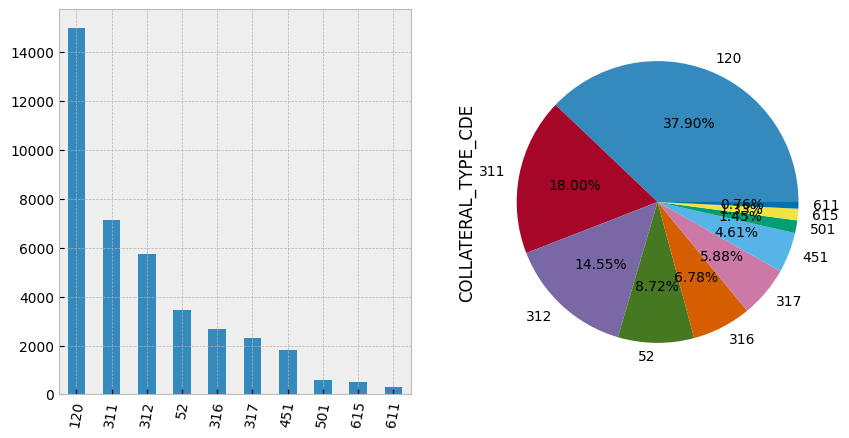

300    18459
100    15170
2       3725
10      1825
600     1366
11       575
8        375
800      325
4        250
12        25
15        25
Name: COLLATERAL_CDE, dtype: int64

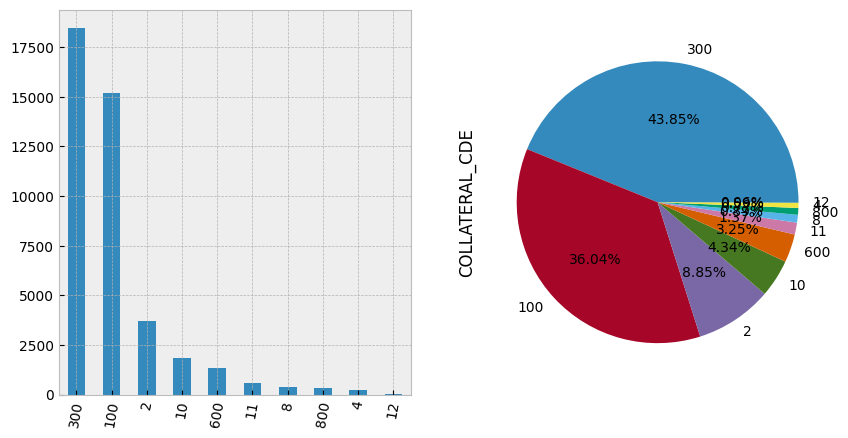

VND    41113
XAU      775
AUD      175
USD       57
Name: CURRENCY_CDE, dtype: int64

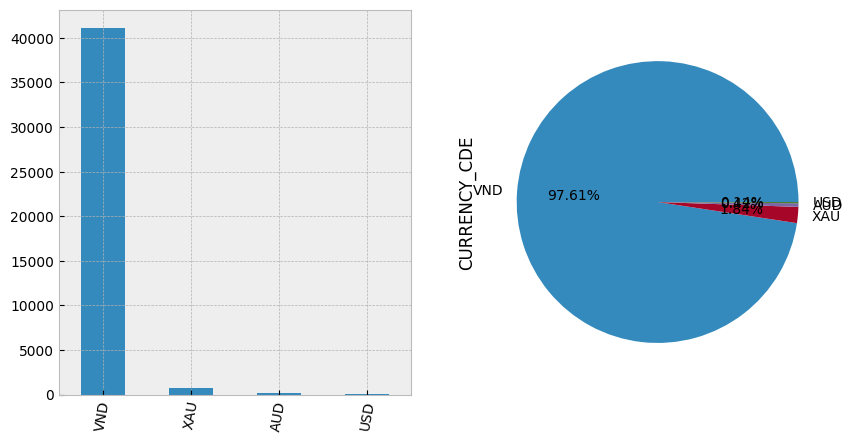

9941    40590
-1       1140
9910      240
9920      100
9990       50
Name: SBVCODE_LVL_3, dtype: int64

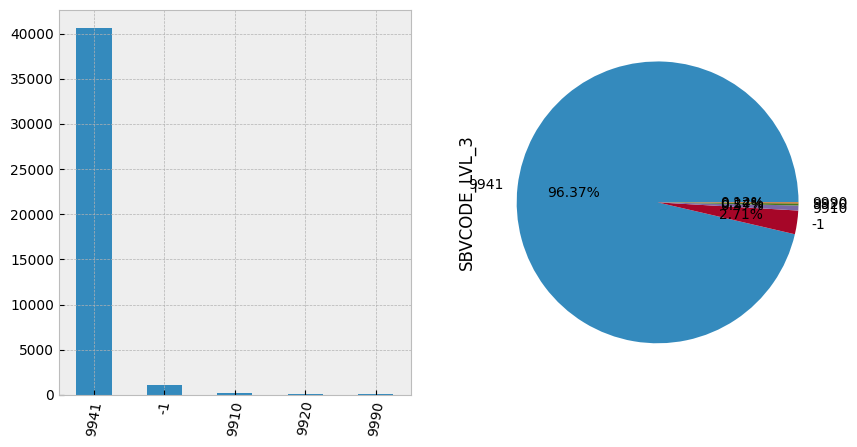

,default_func,remove_mode_value,logx
count,42120.000,29258.000,29258.000
count_pct_chg,100.000,-30.537,-30.537
mean,86362.199,124327.122,6.121
mean_pct_chg,100.000,43.960,-99.993
median,8.000,1342.000,7.202
median_pct_chg,100.000,16675.000,-9.976
min,1.000,2.000,0.693
min_pct_chg,100.000,100.000,-30.685
max,994691.000,994691.000,13.810
max_pct_chg,100.000,0.000,-99.999


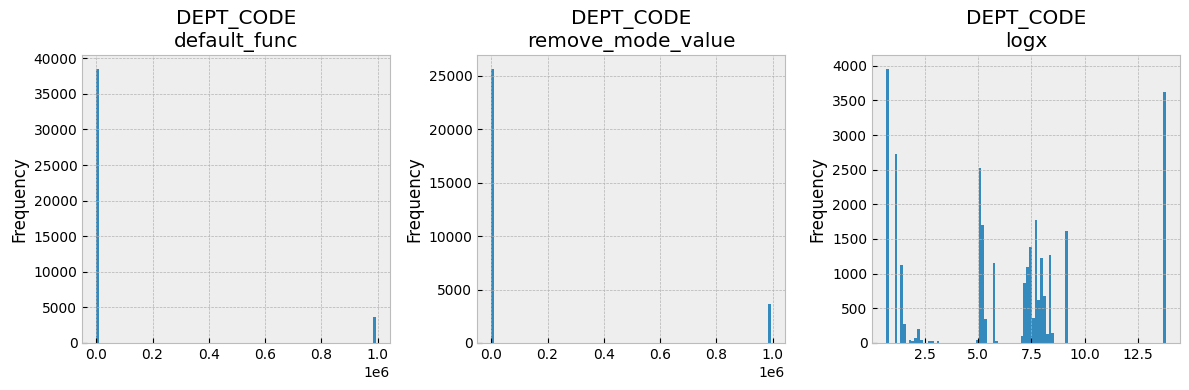

UPDATE THEO TT02 NHNN                         1225
DO UBND HUYEN PHU TAN CAP                      332
|                                              150
VAY CAM CO                                     125
STK060075552788 TRAN THI BICH HONG             100
                                              ... 
XNB 202226499013 TRAN QUOC OAI                   1
NNB LE THI HANG                                  1
DO SO TN & MT TINH AN GIANG CAP                  1
NNB QSDD: D 587949-HUNG                          1
NNB LAI QUOC VUONG|02TT-LD14287000060/HDTC       1
Name: NOTES, Length: 661, dtype: int64

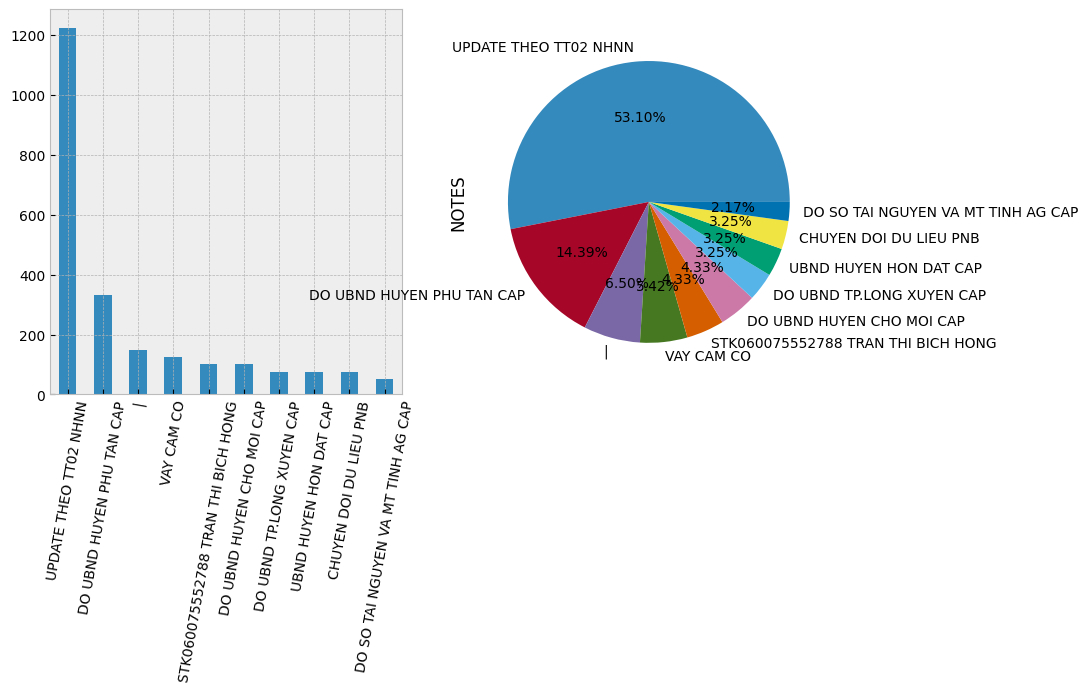

LIQ    36397
CUR     5723
Name: STATUS, dtype: int64

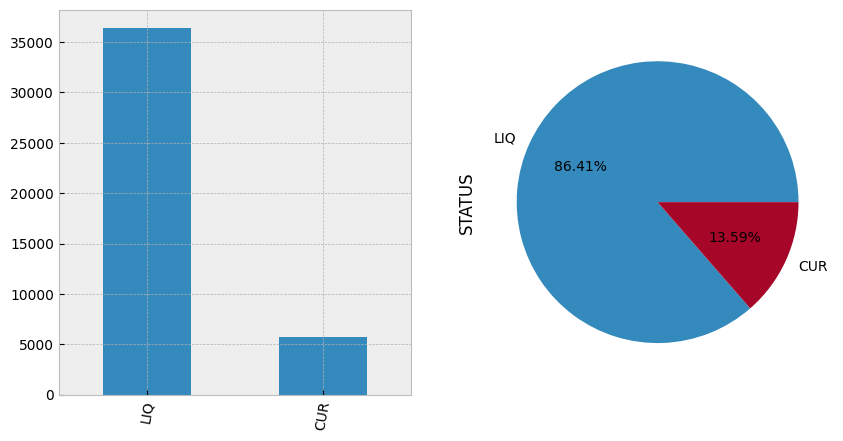

20120122M0622    25
20110204M0104    25
20120312M0612    25
Name: REVIEW_DATE_FQU, dtype: int64

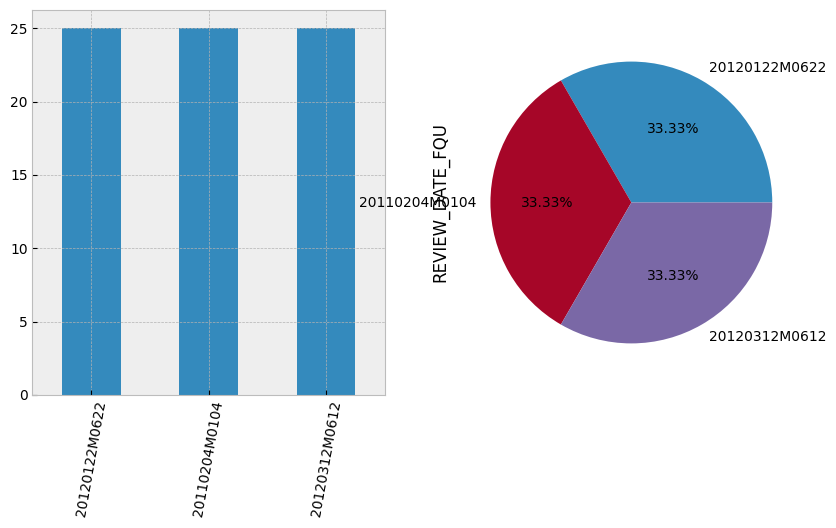

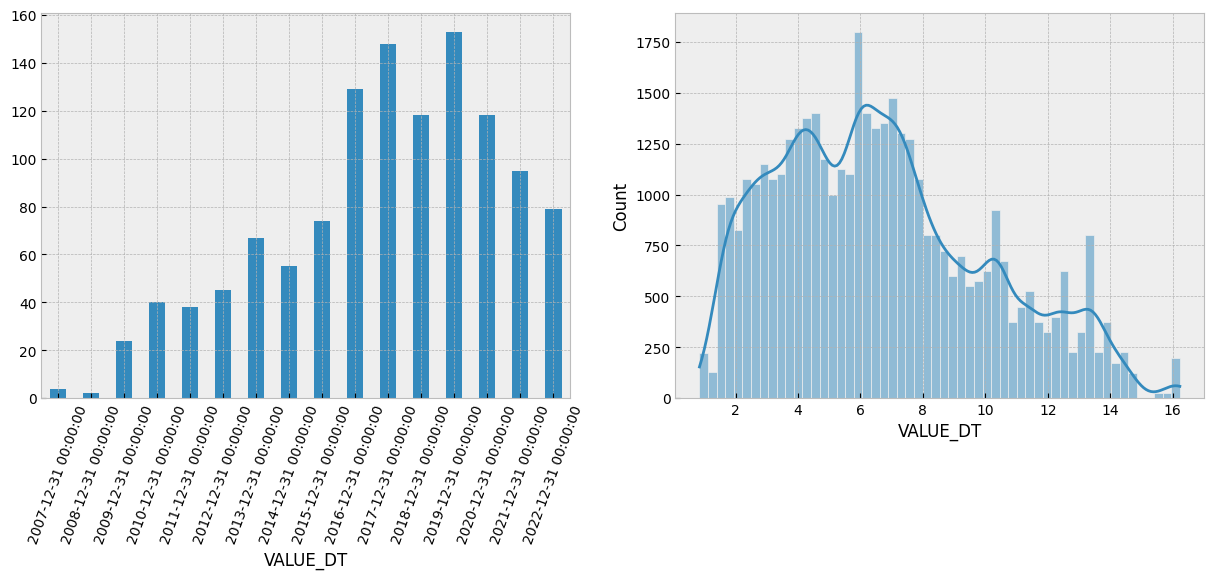

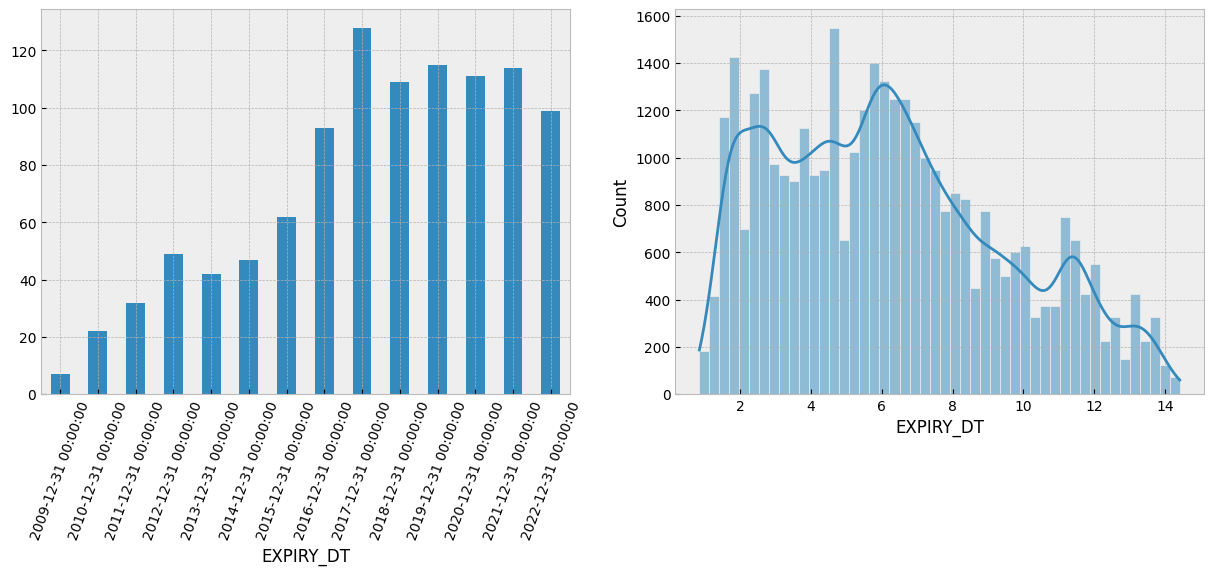

,default_func,remove_mode_value,logx
count,42120.000,40859.000,40859.000
count_pct_chg,100.000,-2.994,-2.994
mean,845350675.628,856008968.831,19.452
mean_pct_chg,100.000,1.261,-100.000
median,434000000.000,410000000.000,19.832
median_pct_chg,100.000,-5.530,-100.000
min,4.000,4.000,1.386
min_pct_chg,100.000,0.000,-65.343
max,27200000000.000,27200000000.000,24.026
max_pct_chg,100.000,0.000,-100.000


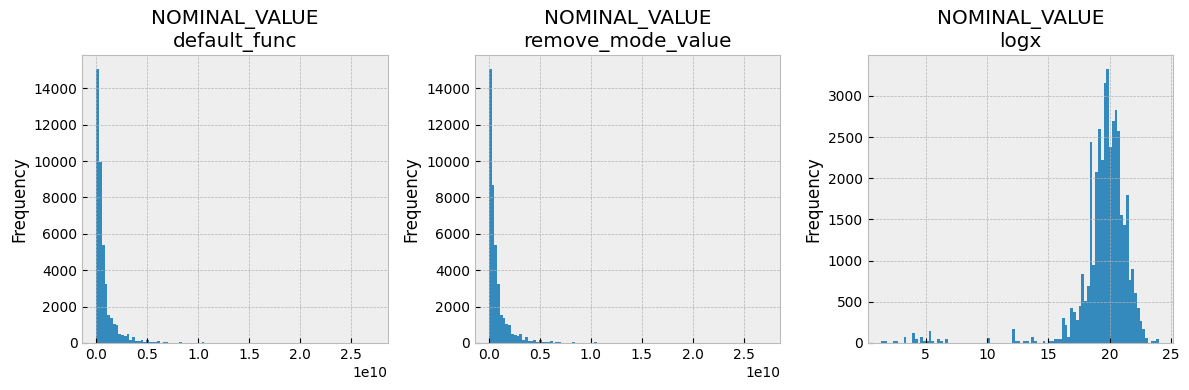

,default_func,remove_mode_value,logx
count,1450.000,1075.000,1075.000
count_pct_chg,100.000,-25.862,-25.862
mean,590927794.397,599390978.488,17.941
mean_pct_chg,100.000,1.432,-100.000
median,250000000.000,170000000.000,18.951
median_pct_chg,100.000,-32.000,-100.000
min,25.000,25.000,3.219
min_pct_chg,100.000,0.000,-87.124
max,7000000000.000,7000000000.000,22.669
max_pct_chg,100.000,0.000,-100.000


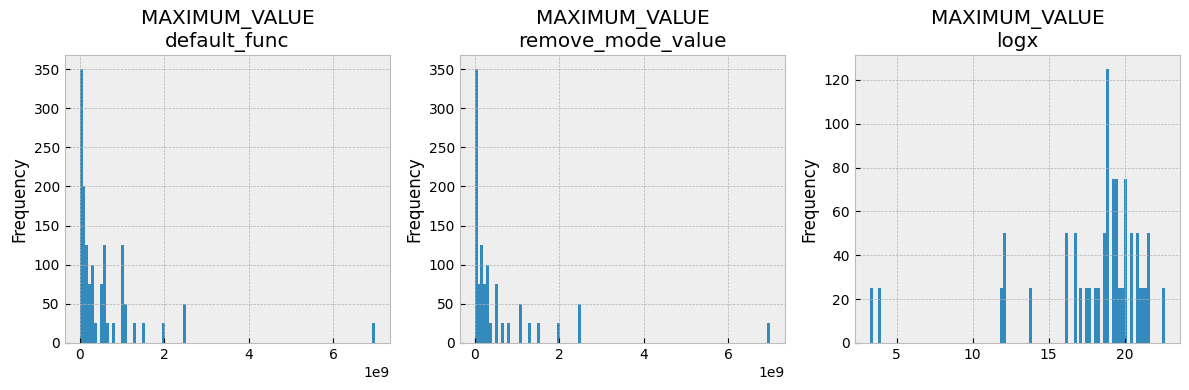

,default_func,remove_mode_value,logx
count,42120.000,39531.000,39531.000
count_pct_chg,100.000,-6.147,-6.147
mean,564017641.666,594407504.667,19.091
mean_pct_chg,100.000,5.388,-100.000
median,280000000.000,300000000.000,19.519
median_pct_chg,100.000,7.143,-100.000
min,4.000,4.000,1.386
min_pct_chg,100.000,0.000,-65.343
max,23067000000.000,23067000000.000,23.862
max_pct_chg,100.000,0.000,-100.000


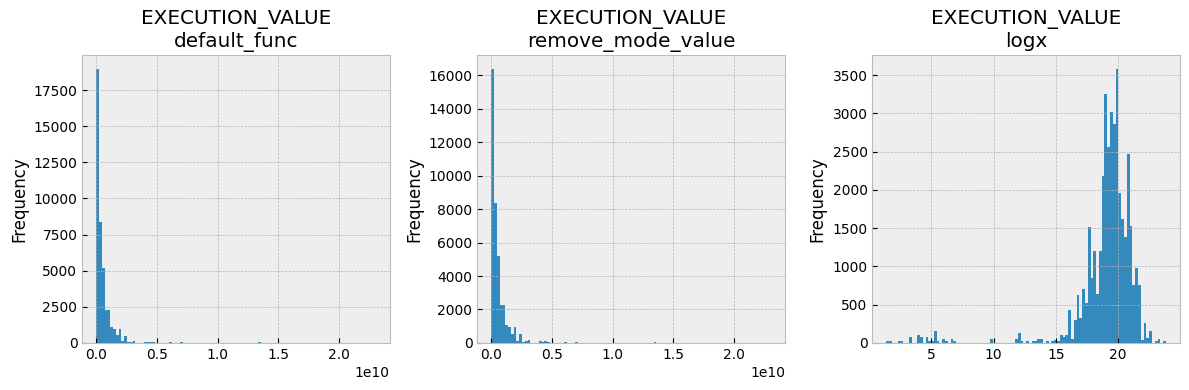

,default_func,remove_mode_value,logx
count,42120.000,5345.000,5345.000
count_pct_chg,100.000,-87.310,-87.310
mean,116561605.607,918535982.816,19.863
mean_pct_chg,100.000,688.026,-100.000
median,0.000,450000000.000,19.925
median_pct_chg,100.000,inf,inf
min,0.000,16790.000,9.729
min_pct_chg,100.000,inf,inf
max,23067000000.000,23067000000.000,23.862
max_pct_chg,100.000,0.000,-100.000


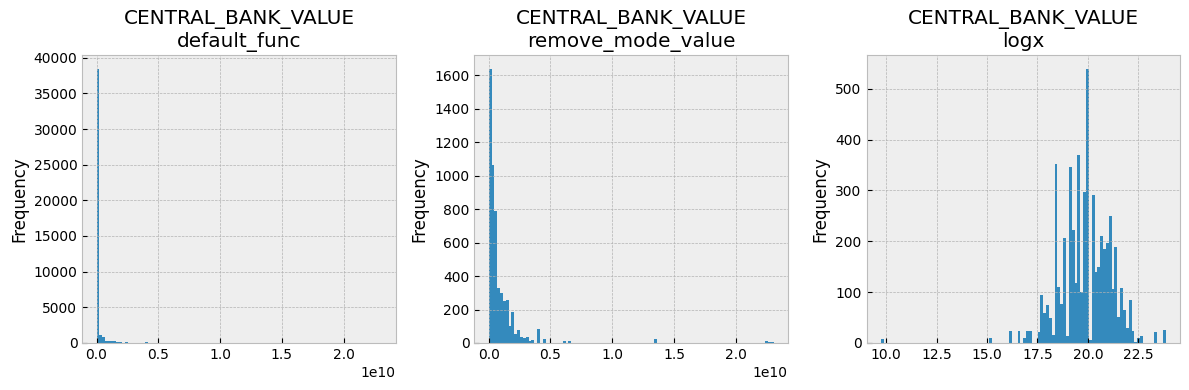

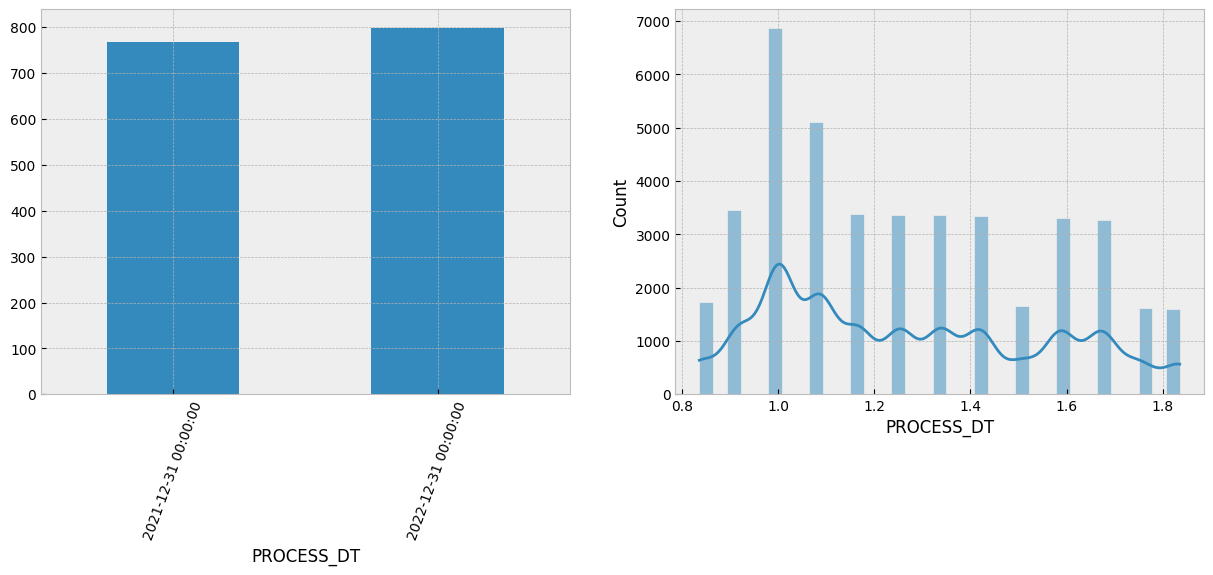

,default_func,remove_mode_value,logx
count,5283.000,5137.000,5137.000
count_pct_chg,100.000,-2.764,-2.764
mean,1673684141.933,1707041721.205,20.520
mean_pct_chg,100.000,1.993,-100.000
median,819000000.000,880000000.000,20.595
median_pct_chg,100.000,7.448,-100.000
min,22744.090,22744.090,10.032
min_pct_chg,100.000,0.000,-99.956
max,27200000000.000,27200000000.000,24.026
max_pct_chg,100.000,0.000,-100.000


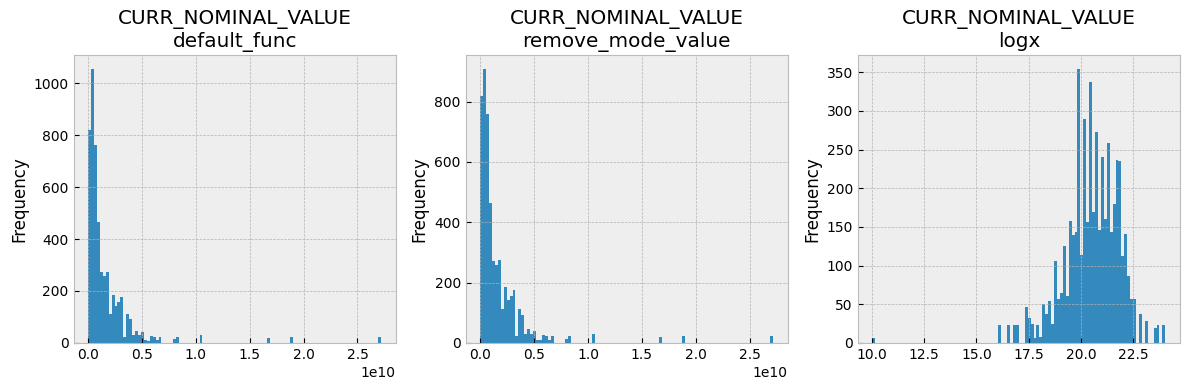

,default_func,remove_mode_value,logx
count,5283.000,5137.000,5137.000
count_pct_chg,100.000,-2.764,-2.764
mean,1674323929.783,1707699692.631,20.532
mean_pct_chg,100.000,1.993,-100.000
median,819000000.000,880000000.000,20.595
median_pct_chg,100.000,7.448,-100.000
min,10000000.000,10000000.000,16.118
min_pct_chg,100.000,0.000,-100.000
max,27200000000.000,27200000000.000,24.026
max_pct_chg,100.000,0.000,-100.000


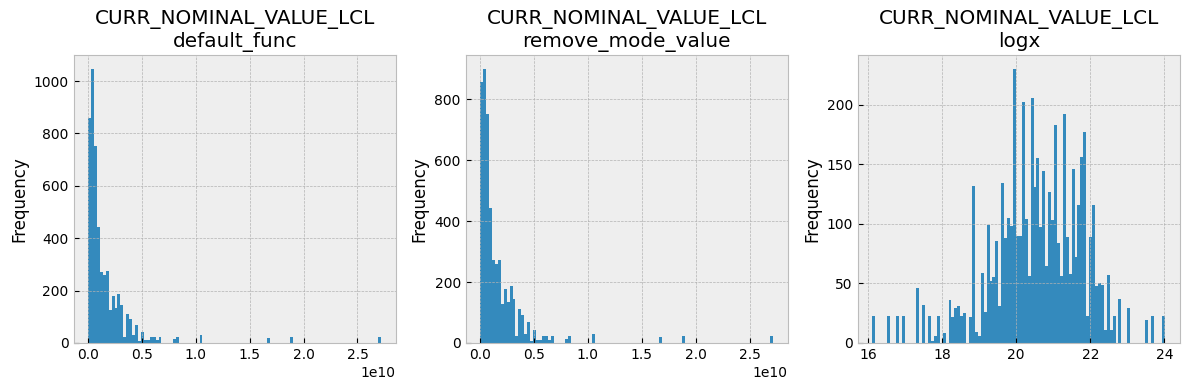

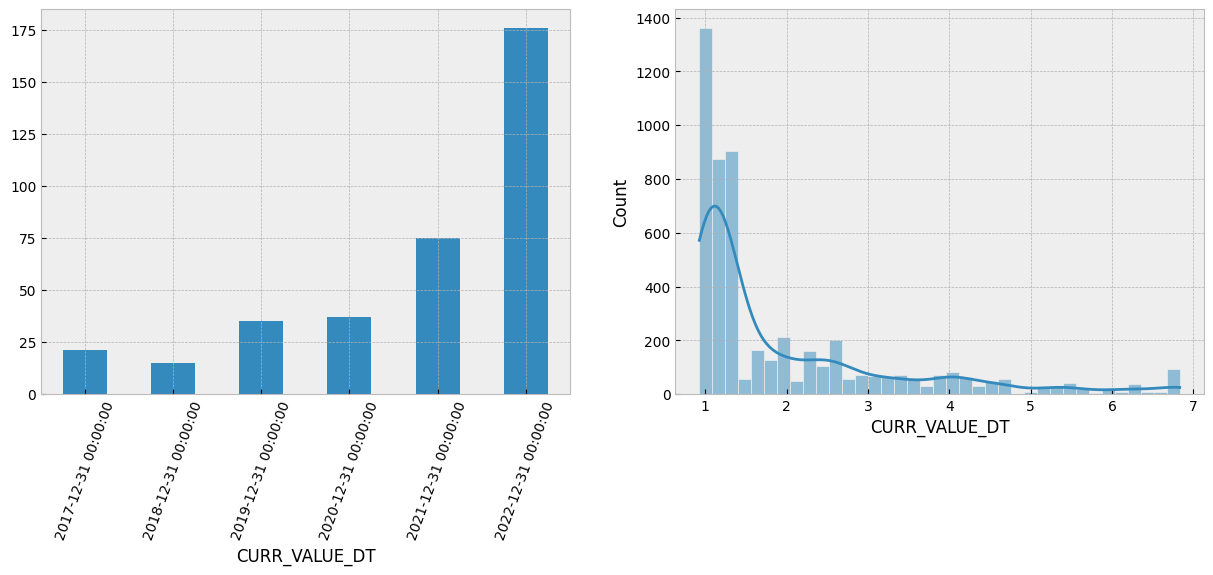

,default_func,remove_mode_value,logx
count,551.000,515.000,515.000
count_pct_chg,100.000,-6.534,-6.534
mean,1430669539.020,1485240613.592,20.197
mean_pct_chg,100.000,3.814,-100.000
median,575000000.000,575000000.000,20.170
median_pct_chg,100.000,0.000,-100.000
min,30000000.000,30000000.000,17.217
min_pct_chg,100.000,0.000,-100.000
max,25380000000.000,25380000000.000,23.957
max_pct_chg,100.000,0.000,-100.000


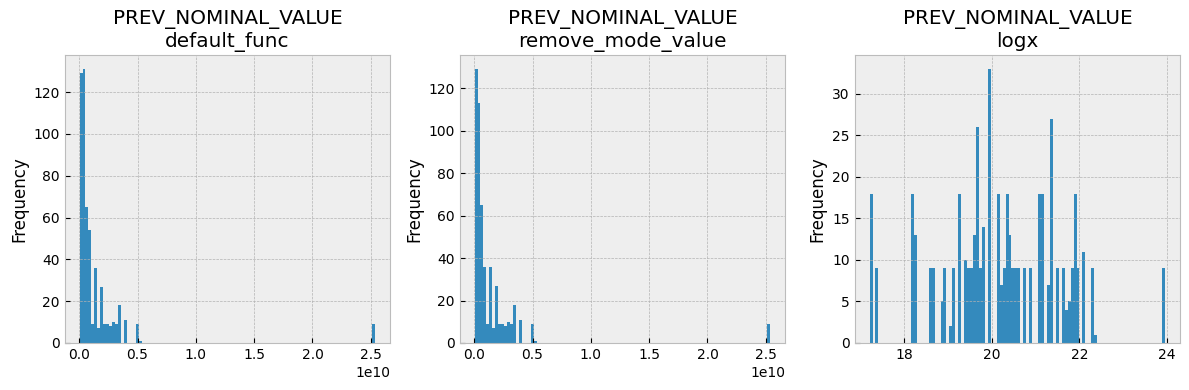

,default_func,remove_mode_value,logx
count,551.000,515.000,515.000
count_pct_chg,100.000,-6.534,-6.534
mean,1430669539.020,1485240613.592,20.197
mean_pct_chg,100.000,3.814,-100.000
median,575000000.000,575000000.000,20.170
median_pct_chg,100.000,0.000,-100.000
min,30000000.000,30000000.000,17.217
min_pct_chg,100.000,0.000,-100.000
max,25380000000.000,25380000000.000,23.957
max_pct_chg,100.000,0.000,-100.000


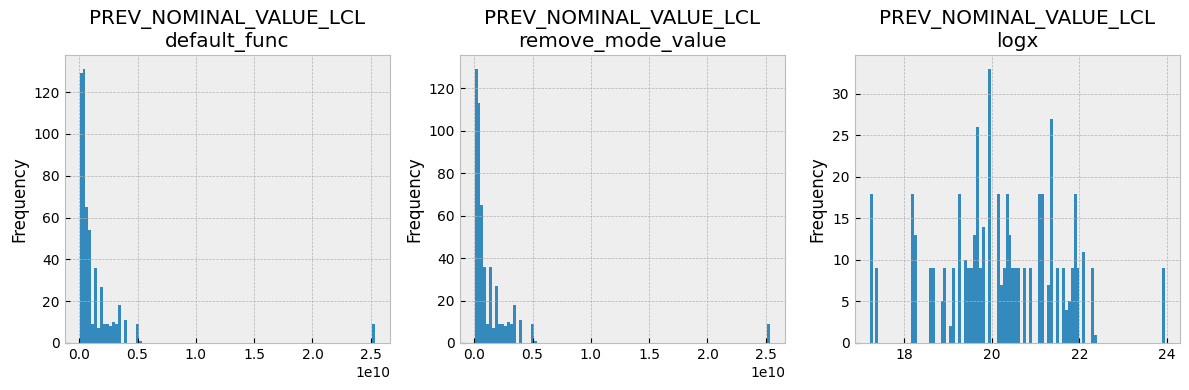

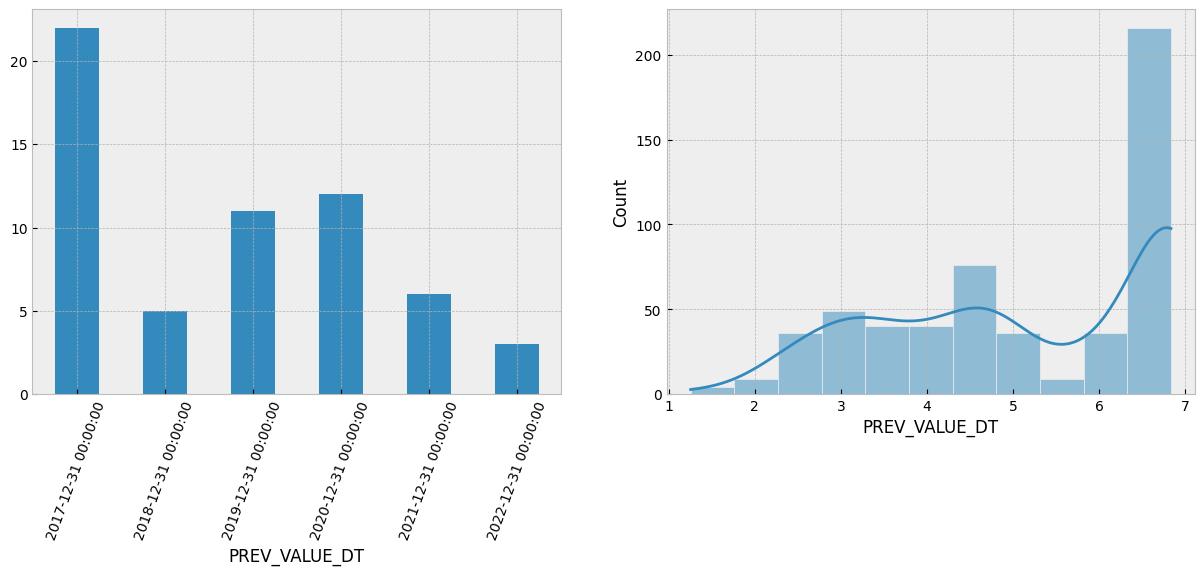

In [24]:
for i, r in valid_info.iterrows():
    if r['Dtype'] == object:
        aly_cat_col(df, [r['Column']])
    elif r['Dtype'] == 'datetime64[ns]':
        aly_datetime(df, r['Column'], 'CUSTOMER_CDE')
    else:
        plot_multi_hist_aly(df, [r['Column']])
    print('\n\n\n')

In [25]:
df.columns, len(df.columns)

(Index(['COLLATERAL_ID', 'COMPANY_KEY', 'COMPANY_CDE', 'DAY_KEY',
        'SUB_BRANCH_KEY', 'SUB_BRANCH_CDE', 'CUSTOMER_KEY', 'CUSTOMER_CDE',
        'COLLATERAL_TYPE_CDE', 'COLLATERAL_CDE', 'CURRENCY_CDE',
        'SBVCODE_LVL_3', 'DEPT_CODE', 'DESCRIPTION', 'ADDRESS', 'NOTES',
        'STATUS', 'REVIEW_DATE_FQU', 'LOCAL_REF', 'VALUE_DT', 'EXPIRY_DT',
        'REVALUED_DT', 'NOMINAL_VALUE', 'MAXIMUM_VALUE', 'EXECUTION_VALUE',
        'CENTRAL_BANK_VALUE', 'REVALUED_AMOUNT', 'THIRD_PARTY_VALUE',
        'GEN_LEDGER_VALUE', 'PROCESS_DT', 'REC_CREATE_DT', 'REC_UPDATE_DT',
        'COLLATERAL_TYPE_CDE_OLD', 'COLLATERAL_CDE_OLD', 'INPUTTER',
        'AUTHOR_ID', 'CURR_NOMINAL_VALUE', 'CURR_NOMINAL_VALUE_LCL',
        'CURR_VALUE_DT', 'PREV_NOMINAL_VALUE', 'PREV_NOMINAL_VALUE_LCL',
        'PREV_VALUE_DT'],
       dtype='object'),
 42)

In [26]:
valid_info.set_index('Column').index, len(valid_info['Column'].index)

(Index(['COLLATERAL_TYPE_CDE', 'COLLATERAL_CDE', 'CURRENCY_CDE',
        'SBVCODE_LVL_3', 'DEPT_CODE', 'NOTES', 'STATUS', 'REVIEW_DATE_FQU',
        'VALUE_DT', 'EXPIRY_DT', 'NOMINAL_VALUE', 'MAXIMUM_VALUE',
        'EXECUTION_VALUE', 'CENTRAL_BANK_VALUE', 'PROCESS_DT',
        'CURR_NOMINAL_VALUE', 'CURR_NOMINAL_VALUE_LCL', 'CURR_VALUE_DT',
        'PREV_NOMINAL_VALUE', 'PREV_NOMINAL_VALUE_LCL', 'PREV_VALUE_DT'],
       dtype='object', name='Column'),
 21)

In [27]:
df.columns

Index(['COLLATERAL_ID', 'COMPANY_KEY', 'COMPANY_CDE', 'DAY_KEY',
       'SUB_BRANCH_KEY', 'SUB_BRANCH_CDE', 'CUSTOMER_KEY', 'CUSTOMER_CDE',
       'COLLATERAL_TYPE_CDE', 'COLLATERAL_CDE', 'CURRENCY_CDE',
       'SBVCODE_LVL_3', 'DEPT_CODE', 'DESCRIPTION', 'ADDRESS', 'NOTES',
       'STATUS', 'REVIEW_DATE_FQU', 'LOCAL_REF', 'VALUE_DT', 'EXPIRY_DT',
       'REVALUED_DT', 'NOMINAL_VALUE', 'MAXIMUM_VALUE', 'EXECUTION_VALUE',
       'CENTRAL_BANK_VALUE', 'REVALUED_AMOUNT', 'THIRD_PARTY_VALUE',
       'GEN_LEDGER_VALUE', 'PROCESS_DT', 'REC_CREATE_DT', 'REC_UPDATE_DT',
       'COLLATERAL_TYPE_CDE_OLD', 'COLLATERAL_CDE_OLD', 'INPUTTER',
       'AUTHOR_ID', 'CURR_NOMINAL_VALUE', 'CURR_NOMINAL_VALUE_LCL',
       'CURR_VALUE_DT', 'PREV_NOMINAL_VALUE', 'PREV_NOMINAL_VALUE_LCL',
       'PREV_VALUE_DT'],
      dtype='object')

## COMPARE SAMPLES - SUB1/2/3